# Analiza vulgarnosti u Tarantinovim filmovima

Alati: Jupyter Notebook, Python (pandas, matplotlib i sl.), SQLite

In [1]:
import pandas as pd
df = pd.read_csv('profanity.csv')
df

,movie,type,word,minutes_in
0,Reservoir Dogs,word,dick,0.40
1,Reservoir Dogs,word,dicks,0.43
2,Reservoir Dogs,word,fucked,0.55
3,Reservoir Dogs,word,fucking,0.61
4,Reservoir Dogs,word,bullshit,0.61
...,...,...,...,...
1889,Jackie Brown,word,motherfucker,141.93
1890,Jackie Brown,word,ass,142.43
1891,Jackie Brown,word,fucking,142.47
1892,Jackie Brown,word,goddamn,142.97


In [2]:
data = {}
with open('profanity.csv') as file:
    for f in list(enumerate(file.readlines()[1:])):
        data[f[0]] = f[1:][0].rstrip().split(',')

In [3]:
rijeci = set(df.word)

In [5]:
filmovi = set(df.movie)

In [6]:
film = [('Django Unchained', 84, 2012, 165), 
 ('Pulp Fiction', 89, 1994, 154), 
 ('Inglorious Basterds', 83, 2009, 153), 
 ('Kill Bill: Vol. 1', 81, 2003, 91), 
 ('Jackie Brown', 75, 1997, 154), 
 ('Reservoir Dogs', 83, 1992, 99), 
 ('Kill Bill: Vol. 2', 80, 2004, 137)]

In [7]:
tip_vulgarnosti = set(df.type)

In [8]:
rijec = set(df.word)
rijec.add('death')

In [9]:
vulg = {}.fromkeys(rijec, [])
for entry in data:
    time = [[ entry, data[entry][3] ]]
    if data[entry][1] == 'word':
        vulg[data[entry][2]] = vulg[data[entry][2]] + time
    elif data[entry][1] == 'death':
        vulg['death'] = vulg['death'] + time

In [10]:
sorted_vulgs = []
only_sorted = []
base_words = ['shit', 'fuck', 'ass', 'damn', 'dick', 'cock', 'bitch', 'cunt', ]
for word in vulg.keys():
    for base in base_words:
        if type(word) == type('') and base in word:
            sorted_vulgs.append((base, word))
            only_sorted.append(word)

In [11]:
sorted_vulgs_db = sorted_vulgs + [(r,r) for r in rijec if r not in only_sorted]
sorted_vulgs_db[:5]

[('fuck', 'motherfucker'),
 ('shit', 'horeshit'),
 ('damn', 'damned'),
 ('fuck', 'fuck'),
 ('fuck', 'fuckhead')]

In [12]:
korijen = base_words + [r for r in rijec if r not in only_sorted]

In [13]:
korijen_db = []
for item in korijen:
    korijen_db.append((item,))

In [14]:
kategorije = ['fekalije', 'seks', 'psovke', 'pogrdnost', 'nacija', 'rasa', 'smrt']
kategorije_db = []
for item in kategorije:
    kategorije_db.append((item,))

In [15]:
korijen_kat = [('shit', 'fekalije'),
('fuck', 'seks'),
('ass', 'seks'),
('damn', 'psovke'),
('dick', 'seks'),
('cock', 'seks'),
('bitch', 'pogrdnost'),
('cunt', 'seks'),
('slut', 'seks'),
('slope', 'rasa' ),
('jap', 'nacija'),
('pussy', 'seks'),
('death', 'smrt'),
('n-word ', 'rasa'),
('bastards', 'pogrdnost'),
('gooks', 'nacija'),
('hell', 'psovka'),
('jew (verb)', 'pogrdnost'),
('faggot', 'seks'),
('squaw', 'seks'),
('wetback', 'nacija'),
('merde', 'fekalije'),
('bastard', 'pogrdnost'),
('gook', 'nacija'),
('japs', 'nacija'),
('negro ', 'rasa')]

## Upravljanje bazom podataka

In [16]:
import sqlite3

In [17]:
conn = sqlite3.connect('baza.db')
c = conn.cursor()



### Tablica korijen
```sqlite
CREATE TABLE korijen(
    korijen_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
    kategorija_fk INTEGER   --- vraceno u korijen
    FOREIGN KEY (kategorija_fk)
        REFERENCES kategorija (kategorija_id)

);
```

```sqlite
INSERT INTO korijen(naziv) VALUES (?);
```

In [18]:
drop_table_korijen = '''
DROP TABLE korijen;
'''
c.execute(drop_table_korijen)

create_table_korijen='''
CREATE TABLE korijen(
    korijen_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT,
    kategorija_fk INTEGER,
    FOREIGN KEY (kategorija_fk)
        REFERENCES kategorija (kategorija_id)

);
'''

c.execute(create_table_korijen)

insert_into_korijen = '''
INSERT INTO korijen(naziv) VALUES (?);
'''
c.executemany(insert_into_korijen, korijen_db)
conn.commit()

### Tablica kategorija

```sqlite
CREATE TABLE kategorija(
    kategorija_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
);
```

```sqlite
INSERT INTO kategorija(naziv) VALUES (?);
```


In [19]:
drop_table_kat = '''
DROP TABLE kategorija;
'''
c.execute(drop_table_kat)

create_table_kat = '''
CREATE TABLE kategorija(
    kategorija_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
);'''

c.execute(create_table_kat)
insert_into_kat = '''
INSERT INTO kategorija(naziv) VALUES (?);
'''
c.executemany(insert_into_kat, kategorije_db)
conn.commit()

### Tablica film
```sqlite
CREATE TABLE film(
    film_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT NOT NULL,
    godina INTEGER,
    trajanje INTEGER, --- minute
    ocjena INTEGER, --- 0 <= ocjena <= 100
    CHECK (ocjena <= 100 AND
           ocjena >= 0)
);
```
```sqlite
INSERT INTO film (naziv, ocjena, godina) VALUES (?, ?, ?);
```

In [20]:
drop_table_film = '''DROP TABLE film;'''
c.execute(drop_table_film)

create_table_film = '''
CREATE TABLE film(
    film_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT NOT NULL,
    godina INTEGER,
    trajanje INTEGER,
    ocjena INTEGER
    CHECK (ocjena <= 100 AND
           ocjena >= 0)
);
'''
c.execute(create_table_film)

insert_into_film = '''
INSERT INTO film (naziv, ocjena, godina, trajanje) VALUES (?, ?, ?, ?);
'''
c.executemany(insert_into_film, film)
conn.commit()

### Tablica rijec

```sqlite
CREATE TABLE rijec (
    rijec_id INTEGER PRIMARY KEY, ---non-autoincrement!
    rijec TEXT NOT NULL,
    vrijeme REAL NOT NULL,
    film_fk INTEGER,
    FOREIGN KEY (film_dk)
        REFERENCES film (film_id) 
    korijen_fk INTEGER,
    FOREIGN KEY (korijen_fk)
        REFENCES korijen (korijen_id)
    kategorija_fk INTEGER   --- vraceno u korijen
    FOREIGN KEY (kategorija_fk)
        REFERENCES kategorija (kategorija_id)
);```


```sqlite
INSERT INTO rijec VALUES (?,?,?,NULL,NULL,NULL)

```

In [21]:
drop_table_rijec ='''
DROP TABLE rijec;
'''
c.execute(drop_table_rijec)

create_table_rijec = '''
CREATE TABLE rijec (
    rijec_id INTEGER PRIMARY KEY,
    rijec TEXT NOT NULL,
    vrijeme REAL NOT NULL,
    film_fk INTEGER,
    korijen_fk INTEGER,
    kategorija_fk INTEGER,   --- vraceno u korijen
    FOREIGN KEY (kategorija_fk)
        REFERENCES kategorija (kategorija_id)
    
);
'''
c.execute(create_table_rijec)

insert_into_rijec = '''
INSERT INTO rijec VALUES (?,?,?,NULL,NULL,NULL)
'''
c.executemany(insert_into_rijec, [(a, data[a][2], data[a][3]) for a in data])
conn.commit()

```sqlite
UPDATE rijec SET korijen_fk = (
    SELECT korijen_id FROM korijen
    WHERE naziv = ?
) WHERE rijec = ?
```

In [22]:
update_korijen_fk = '''
UPDATE rijec SET korijen_fk = (
    SELECT korijen_id FROM korijen
    WHERE naziv = ?
) WHERE rijec = ?
'''
c.executemany(update_korijen_fk, sorted_vulgs_db)
conn.commit()

```sqlite
UPDATE rijec SET film_fk = (
    SELECT film_id FROM film
    WHERE naziv = ?
) WHERE rijec_id = ?
```

In [23]:
update_film_fk = '''
UPDATE rijec SET film_fk = (
    SELECT film_id FROM film
    WHERE naziv = ?
) WHERE rijec_id = ?
'''
film_id = [(data[a][0], a) for a in data]
c.executemany(update_film_fk, film_id)
conn.commit()

```sqlite
UPDATE rijec SET kategorija_fk = (
    SELECT kategorija_id FROM kategorija
    WHERE naziv = ?
) WHERE korijen = (
    SELECT korijen_id FROM korijen
    WHERE naziv = ?
);
```

In [24]:
update_kategorija_fk = '''
UPDATE rijec SET kategorija_fk = (
    SELECT kategorija_id FROM kategorija
    WHERE naziv = ?
) WHERE korijen_fk = (
    SELECT korijen.korijen_id
    FROM korijen
    WHERE naziv = ?
);
'''
c.executemany(update_kategorija_fk, [(a[1], a[0]) for a in korijen_kat])
conn.commit()

### Upiti

Ispitivanje postoji li vezanost između količine psovki i ocjene.

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt

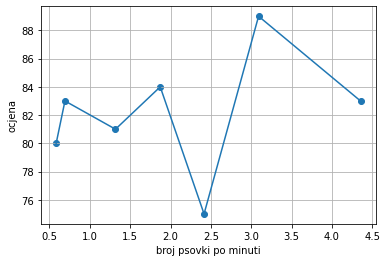

In [27]:
#Ispitivanje postoji li veza izmedu gustoce psovki i ocjene.

avg_per_film = '''
SELECT  CAST (COUNT() as float)/film.trajanje, film.ocjena 
FROM rijec, film
WHERE film_id = film_fk
GROUP BY film_fk
'''
rez = c.execute(avg_per_film).fetchall()

podatci_avg = sorted(rez)
list(zip(*podatci_avg))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('ocjena')
ax1.set_xlabel('broj psovki po minuti')

plt.grid(True)
plt.scatter(*zip(*podatci_avg))
plt.plot(*zip(*podatci_avg))
plt.savefig('rad/slike/psovke_po_minuti.pdf')
plt.show()

In [28]:
from collections import Counter

In [29]:
def psovka_dio_filma(db_cursor, ime_filma, detail = 10, vulg = 'word'):
    vulg = '!' if vulg == 'word' else '='
    upit = '''
    SELECT CAST (rijec.vrijeme/film.trajanje*{0} as INTEGER) as psovka_pc
    FROM film, rijec
    WHERE rijec.film_fk = film_id
        AND rijec.rijec {2}= ''
        AND film.naziv = '{1}'
    '''.format(detail, ime_filma, vulg)
    data = db_cursor.execute(upit).fetchall()
    
    data = list(x[0] for x in data)
    data = dict(Counter(data))
    fig, ax = plt.subplots()
    ax.set_title(ime_filma)
    ax.set_ylabel('Vrijeme')
    ax.set_xlabel('Broj psovki')

    
    fig.tight_layout()
    ax.grid(True)
    ax.bar(data.keys(), data.values())
    plt.savefig("rad/slike/" + ime_filma + "_" + vulg + ".pdf")
    plt.show()

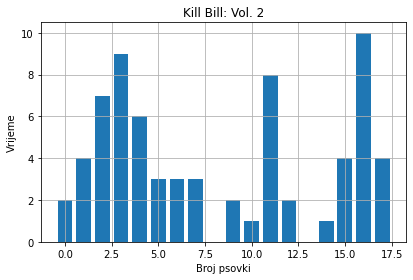

In [30]:
psovka_dio_filma(c, 'Kill Bill: Vol. 2', detail = 20, vulg='word')

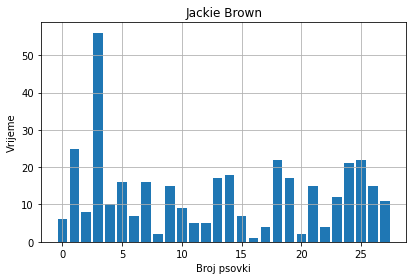

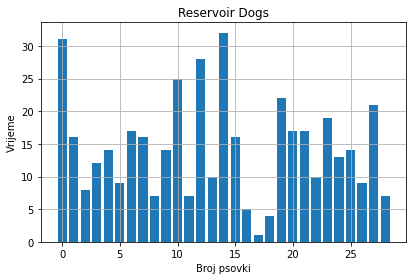

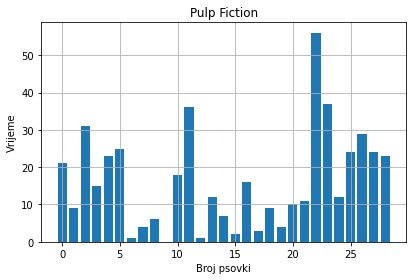

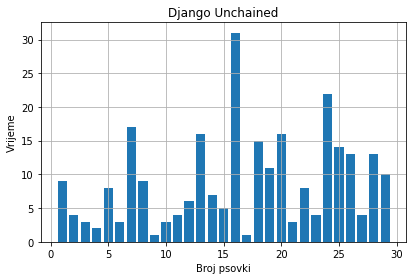

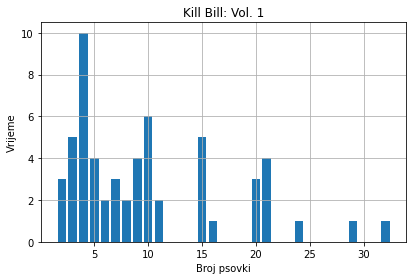

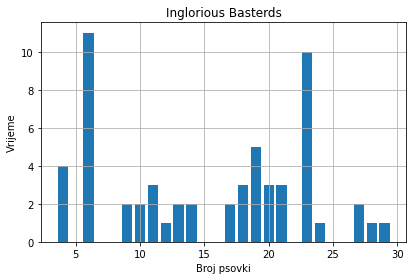

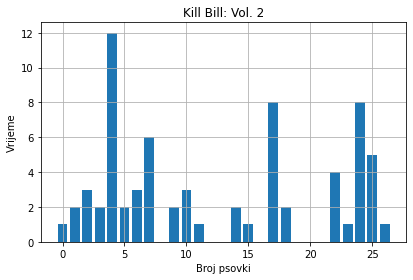

In [31]:
for film in filmovi:
    psovka_dio_filma(c, film, detail = 30)

In [32]:
psovki_po_godini = '''
SELECT  CAST (COUNT() as float)/film.trajanje, film.godina 
FROM rijec, film
WHERE film_id = film_fk
GROUP BY film_fk
'''
rez = c.execute(psovki_po_godini).fetchall()
print(rez)

[(1.8727272727272728, 2012), (3.090909090909091, 1994), (0.6928104575163399, 2009), (1.3186813186813187, 2003), (2.4155844155844157, 1997), (4.353535353535354, 1992), (0.583941605839416, 2004)]


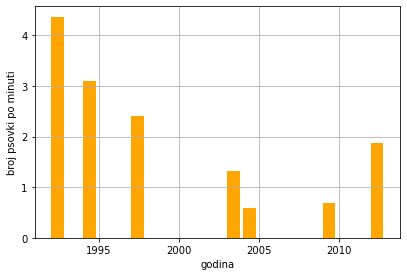

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('broj psovki po minuti')
ax1.set_xlabel('godina')
fig.tight_layout()
plt.grid(True)
plt.xticks([1990, 1995,2000,2005,2010,2015])
plt.bar([int(a[1]) for a in rez], [a[0] for a in rez], align='edge', width=0.8, color='orange')
#plt.plot(*zip(*rez))
plt.savefig('rad/slike/psovke_godine.pdf')
plt.show()

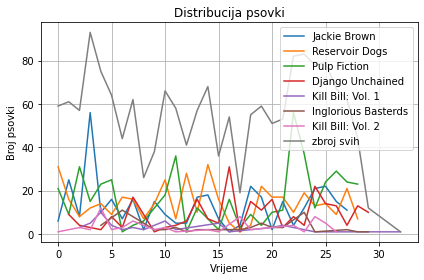

In [34]:
detail = 30
fig, ax = plt.subplots()
ax.set_title('Distribucija psovki')
vulg = '!'
ax.set_xlabel('Vrijeme')
ax.set_ylabel('Broj psovki')
suma = []
for film in filmovi:
    upit = '''
    SELECT CAST (rijec.vrijeme/film.trajanje*{0} as INTEGER) as psovka_pc
    FROM film, rijec
    WHERE rijec.film_fk = film_id
        AND rijec.rijec {2}= ''
        AND film.naziv = '{1}'
    '''.format(detail, film, vulg)
    
    data = c.execute(upit).fetchall()
    data = list(x[0] for x in data)

    data = dict(Counter(data))
    suma.append(data)
    #print(suma)

    

    ax.plot(list(data.keys()), list(data.values()), label=film)
import functools, operator
result = dict(functools.reduce(operator.add, map(Counter, suma))) 
ax.plot(list(result.keys()), list(result.values()), label="zbroj svih")
fig.tight_layout()
ax.grid(True)

plt.legend(loc="upper right")

plt.savefig("rad/slike/filmovi_distribucija_psovki.pdf")
plt.show()



Najcesce psovke:

In [35]:
najcesce_psovke = '''
SELECT kategorija.naziv, COUNT(rijec.kategorija_fk) ---, korijen.naziv
FROM kategorija, rijec
WHERE rijec.kategorija_fk = kategorija_id
GROUP BY rijec.kategorija_fk;
'''
rez = c.execute(najcesce_psovke).fetchall()

[('fekalije', 253), ('seks', 974), ('psovke', 154), ('pogrdnost', 85), ('nacija', 8), ('rasa', 185)]


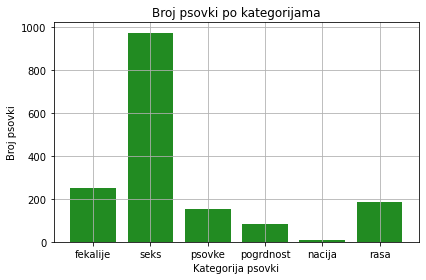

In [36]:
fig, ax = plt.subplots()
ax.set_title('Broj psovki po kategorijama')
ax.set_xlabel('Kategorija psovki')
ax.set_ylabel('Broj psovki')

print(rez)

fig.tight_layout()
ax.grid(False)
ax.bar(*zip(*rez), color='ForestGreen')
ax.grid(True)
plt.savefig("rad/slike/kategorije_total.pdf")
plt.show()

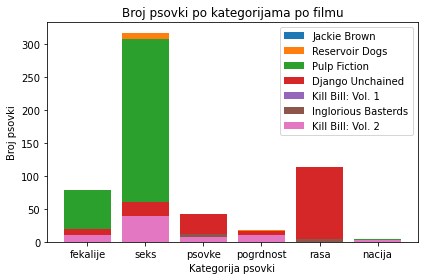

In [37]:
fig, ax = plt.subplots()
ax.set_title('Broj psovki po kategorijama po filmu')
ax.set_ylabel('Broj psovki')
ax.set_xlabel('Kategorija psovki')
for film in filmovi:
    najcesce_psovke = '''
    SELECT kategorija.naziv, COUNT(rijec.kategorija_fk), film.naziv ---, korijen.naziv
    FROM kategorija, rijec, film
    WHERE rijec.kategorija_fk = kategorija_id 
        AND film.film_id = rijec.film_fk
        AND rijec.film_fk = (SELECT film.film_id FROM film WHERE film.naziv = "{}" )
    GROUP BY rijec.kategorija_fk;
    '''.format(film)
    rez = c.execute(najcesce_psovke).fetchall()

    kategorije = list(list(a) for a in zip(*rez))
    fig.tight_layout()
    ax.grid(False)
    ax.bar(kategorije[0], kategorije[1], label=kategorije[2][1])

plt.legend(loc = "best")
plt.savefig("rad/slike/kategorije_total_po_filmovima.pdf")
plt.show()